<h1>Dataquest style RandomForest and ensemble method</h1>

In [10]:
# using pandas to clean the data
import pandas as pd
import numpy as np

titanic = pd.read_csv('data/train.csv',header=0)

In [11]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [13]:
# replace sex column with male = 0, female = 1
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female","Sex"] = 1

In [14]:
# replace Age with median age
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

In [15]:
# convert embarked column to numeric
titanic["Embarked"] = titanic["Embarked"].fillna('S')

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

In [17]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

# n_estimators is the number of trees the forest will make
# min_samples_split is min number of rows we need to make a split
# min_samples_leaf is min number of samples can have at the place where a tree branch ends
clf = RandomForestClassifier(random_state=1,n_estimators=10,min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(clf, titanic[predictors],titanic['Survived'], cv=10)
print(scores.mean())

0.80928413347


<h1>Parameter tuning</h1>

In [18]:
clf = RandomForestClassifier(random_state=1,n_estimators=150,min_samples_split=4,min_samples_leaf=2)

scores = cross_validation.cross_val_score(clf,titanic[predictors],titanic['Survived'],cv=10)
print(scores.mean())

0.829509136307


<h1>Generating New Features</h1>
<p>will look at:</p>
<ol>
<li>length of the name (longer names could indicate higher social status
<li>total number of people in the family (SibSp + Parch)
</ol>

In [19]:
# familysize column
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']

# .apply method generates a new series
titanic['NameLength'] = titanic['Name'].apply(lambda x: len(x))

<h3>Using the title (extraction with a regular expression)</h3>

In [21]:
import re

# function to get title from a name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    # if the title exists return it
    if title_search:
        return title_search.group(1)
    return ""

# get all titles and print how often each one occurs
titles = titanic['Name'].apply(get_title)
print(pd.value_counts(titles))

# map each title to an integer
title_mapping = {"Mr":1,"Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

for k,v in title_mapping.items():
    titles[titles == k] = v
    
# verify everything converted
print(pd.value_counts(titles))

# Add in title column
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


<h2>Family Groups</h2>
<p>survival likely dependent on your family and those around you.  will concatenate someone's last name w/ FamilySize to get unique family id, then can assign code based on the id<p>

In [22]:
import operator

# dictionary mapping family name to id
family_id_mapping = {}

# function to get the id given a row
def get_family_id(row):
    # find last name by splitting on comma
    last_name = row["Name"].split(",")[0]
    # create family id
    family_id = "{0}{1}".format(last_name,row["FamilySize"])
    # look up id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # get max id from mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(),key = operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# get family ids with the apply method
family_ids = titanic.apply(get_family_id,axis=1)

# compress all familes under 3 members into one code
family_ids[titanic["FamilySize"] < 3] = -1

# print count of each unique id
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


<h1>Finding the best features (feature engineering)</h1>
<p>Univariate feature selection (column by column analysis of correlation with target)

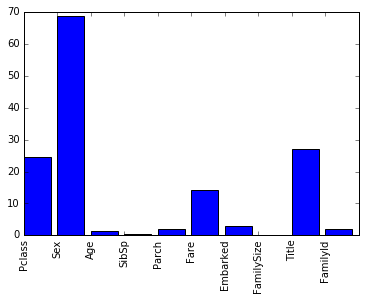

In [29]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
%matplotlib inline 

predictors = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","FamilySize","Title","FamilyId"]

# perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors],titanic["Survived"])

# get raw p-values for each feature, and transform them into scores
scores = -np.log10(selector.pvalues_)

# plot the scores
plt.bar(range(len(predictors)),scores)
plt.xticks(range(len(predictors)),predictors,rotation='vertical')
plt.show()

In [30]:
# pick the four best features
predictors = ['Pclass','Sex','Fare','Title']

clf = RandomForestClassifier(random_state=1,n_estimators=150,min_samples_split=8,min_samples_leaf=4)

scores = cross_validation.cross_val_score(clf,titanic[predictors],titanic['Survived'],cv=10)
print(scores.mean())

0.833953864488


<h1>Ensembling with a linear regression classifier and a gradient boosted tree</h1>
<p>Average the raw probabilities that we get from our classifiers, and then assume anything above 0.5 maps to survived</p>

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold 
import numpy as np

# algorithms we want to ensemble
classifiers = [
    [GradientBoostingClassifier(random_state=1,n_estimators=25,max_depth=3),
        ["Pclass",'Sex','Age','Fare','Embarked','FamilySize','Title','FamilyId']],
    [LogisticRegression(random_state=1),["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# initialize cross validation folds
kf = KFold(titanic.shape[0],n_folds=10,random_state=1)

predictions = []
for train,test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    #make preds for each classifier on each fold
    for clf, predictors in classifiers:
        #fit on training data
        clf.fit(titanic[predictors].iloc[train,:], train_target)
        # select and predict on test fold
        test_predictions = clf.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # use simple ensembling scheme
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # any value over 0.5 is assumed to be 1 prediction
    test_predictions[test_predictions <= 0.5] = 0
    test_predictions[test_predictions > 0.5] = 1
    predictions.append(test_predictions)
    
# put all predictions together into one array
predictions = np.concatenate(predictions,axis=0)

# compute accuracy by comparing to training data
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)

print(accuracy)

0.826038159371


/Users/williamcosby/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:38: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


<h1>Matching changes on the test set</h1>

In [60]:
titanic_test = pd.read_csv('data/test.csv',header=0)

In [61]:
# missing values
# replace sex column with male = 0, female = 1
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female","Sex"] = 1
# replace Age with median age
titanic_test["Age"] = titanic_test["Age"].fillna(titanic_test["Age"].median())
# median fare
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median())
# convert embarked column to numeric
titanic_test["Embarked"] = titanic_test["Embarked"].fillna('S')

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Sincock0': 813, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Walcroft0': 897, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Andersen0': 829, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Peltomaki0': 725, 'Long0': 632, 'Cassebeer0': 809, 'Portaluppi0': 858, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Howard0': 862, 'Smyth0': 805, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Sadowitz0': 878, 'Astor1': 571, 'Patchett0': 480, 'Denbury0': 891, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Lindeberg-Lind0': 793, 'Hassab0': 558, 'Badman0': 755, 'Aronsson0': 914, 'Sa

<h1>Predicting on the test set</h1>

In [62]:
titanic_test.head(3)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null object
FamilySize     418 non-null int64
FamilyId       418 non-null int64
NameLength     418 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 49.1+ KB


In [64]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    print(i)
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

2
2


In [65]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [67]:
submission.to_csv('models/ensemble.csv',index=False)

In [ ]:

predictions_file = open("models/ensemble.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'